In [1]:
import matplotlib.dates as mdates
import utils
import numpy
import scipy
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import cmocean
import pandas
import datetime
import netCDF4
from matplotlib import ticker
import gsw
import xarray
import matplotlib
from matplotlib.dates import date2num
import limits_ranges
import string
import warnings
warnings.filterwarnings("ignore")
import importlib # to be able to reload user modules with importlib.reload(utils)
importlib.reload(utils)
limits = limits_ranges.full_range()
dfnew, newprofiles = utils.create_dataframe(pfloat='new', force_reconstruction=False)
dfold, oldprofiles = utils.create_dataframe(pfloat='old', force_reconstruction=False)

Returning previously computed DataFrame...
Returning previously computed DataFrame...


Returning previously computed DataFrame...
Returning previously computed DataFrame...


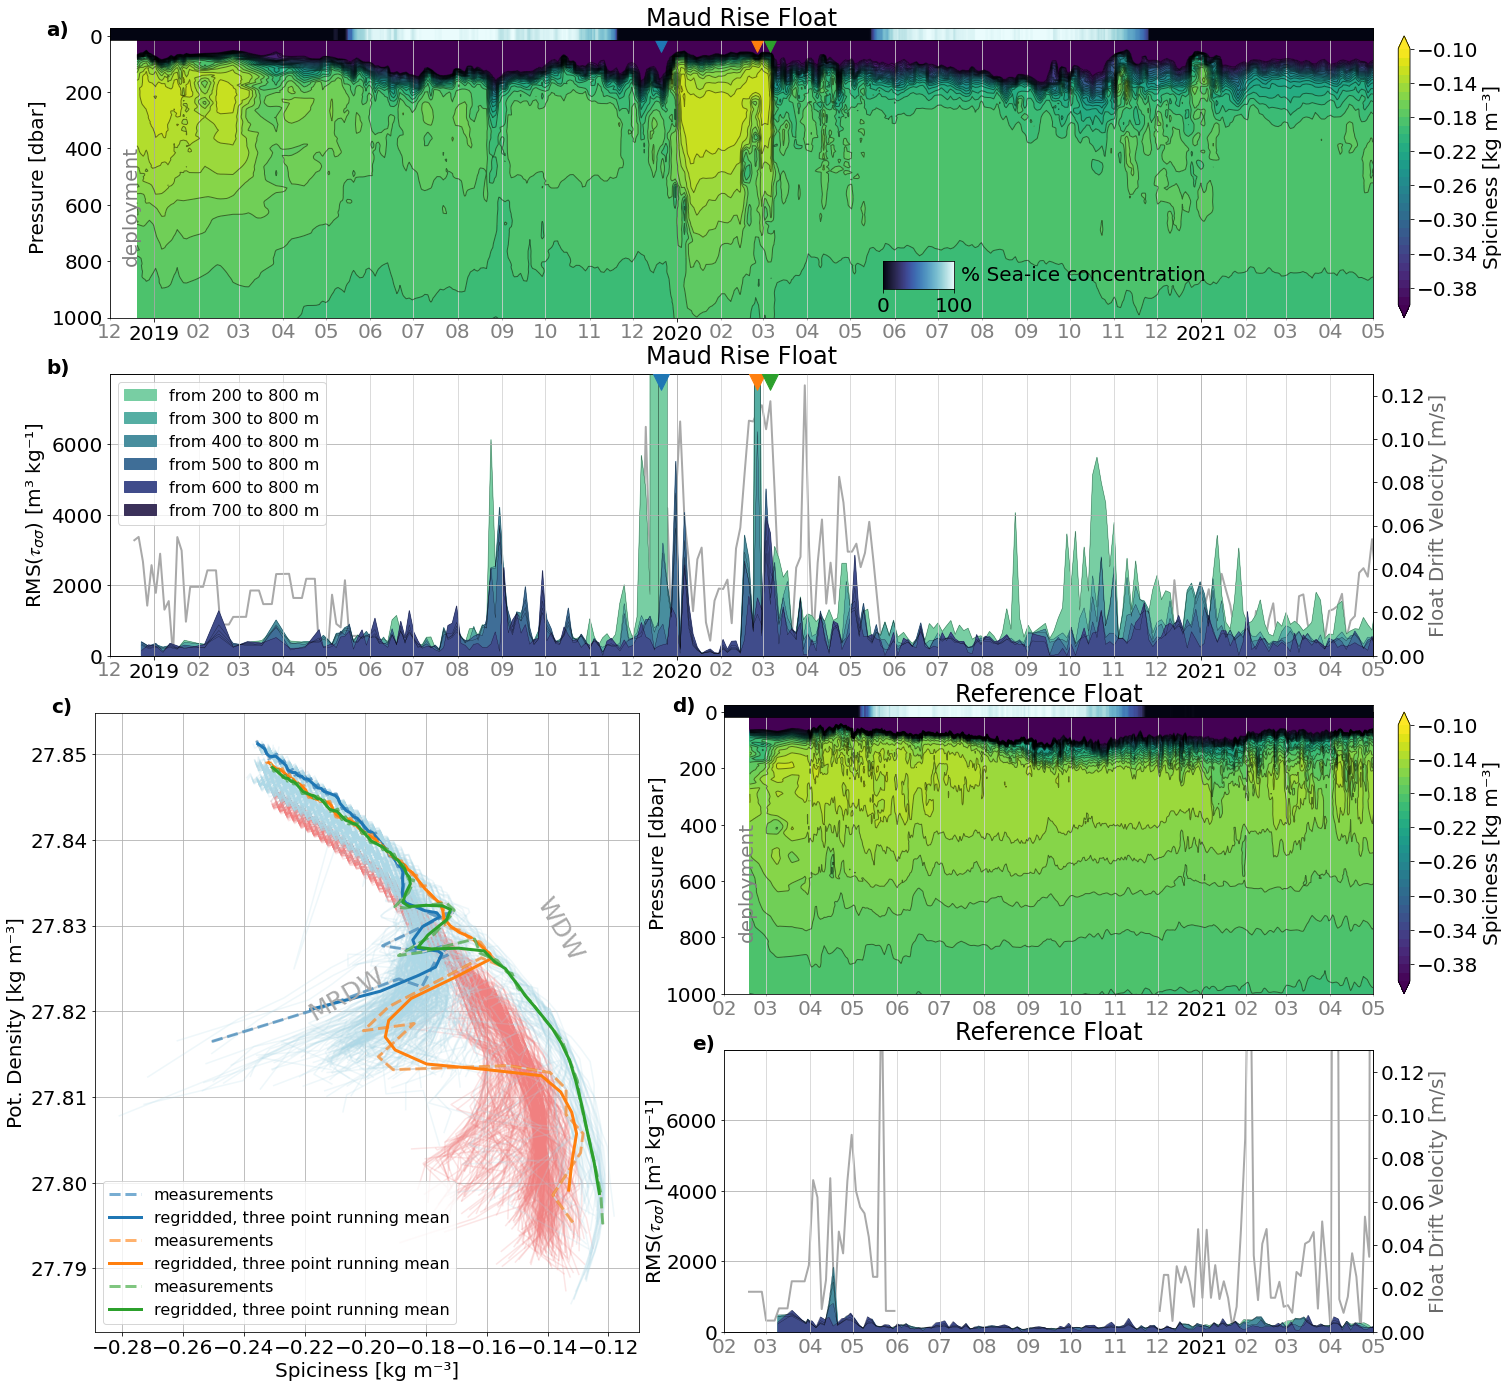

In [2]:
# This is an experiment to use the unused space of the new floats time axis for another subplot
importlib.reload(utils)
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

original_method = True
if original_method:
    ylim=8000#None
else:
    ylim=17500

plt.rcParams['contour.negative_linestyle'] = 'solid'

mixlat = []
mixlon = []

floatdict = {'300234068638900.nc':'Reference Float', 
                 '300234067208900.nc':'Maud Rise Float',
                 'GL_PR_PF_5905382.nc':'SOCCOM float 5905382',
                 '5904468_Mprof.nc':'SOCCOM float 5904468',
                 '5904471_Mprof.nc':'SOCCOM float 5904471',
                 'GL_PR_PF_5905382.nc':'SOCCOM float 5905382'
            }

comparisons = ([#['300234067208900.nc','GL_PR_PF_5905382.nc'],
               #['300234067208900.nc', '300234068638900.nc']])#,'GL_PR_PF_5905382.nc'], 
               #['5904468_Mprof.nc', '5904471_Mprof.nc'],
                ['old', 'new']])


for ci,comparison in enumerate(comparisons):
    
    df1, profiles1 = utils.create_dataframe(pfloat=comparison[0], force_reconstruction=False)
    df2, profiles2 = utils.create_dataframe(pfloat=comparison[1], force_reconstruction=False)
    
    profiles1 = profiles1[1:]
        
    plt.rc('font', size=20)
    
    fig = plt.figure(figsize=[21,20])
    gs = fig.add_gridspec(nrows=4, ncols=3, left=0.07, right=0.93, bottom=0.05, top=0.95,
                            #sharex=False,#False,#'False', 
                            height_ratios=[1,1,1,1], 
                            width_ratios=[1,1.1, 0.02], wspace=0.06)
    
    # trajectory-plots
    ax_spice_old = fig.add_subplot(gs[0,0:2])
    ax_spice_new = fig.add_subplot(gs[2,1])
    ax_cb_spice_old = fig.add_subplot(gs[0,2])
    ax_cb_spice_new = fig.add_subplot(gs[2,2])
    
    # rms-filled-line-plots
    ax_rms_old = fig.add_subplot(gs[1,0:2], sharex=ax_spice_old)
    ax_rms_new = fig.add_subplot(gs[3,1], sharex=ax_spice_new)
    
    gs2 = fig.add_gridspec(left=0.06, right=0.42, top=0.48, bottom=0.05)
    ax_questionmark = fig.add_subplot(gs2[:,:])

    colors = ['tab:red', 'tab:blue']
    linestyles = ['--', 'solid']
    norm = matplotlib.colors.Normalize(vmin=0, vmax=800)
    cmap = cmocean.cm.deep
    cmap2 = plt.cm.autumn
    cmaps = [cmap, cmap, cmap]
    dindexdict = {0:ax_rms_old, 1:ax_rms_new}
    
    for dindex,profiles in enumerate([profiles1, profiles2]):
        
        ax = dindexdict[dindex]
        axtwin = ax.twinx()
        axtwin.set_ylabel('Float Drift Velocity [m/s]', color='dimgrey')  # we already handled the x-label with ax1
        df_col = xarray.open_dataset('../data/collocation_%s.nc'%comparison[dindex])

        # start block for plotting the float drift velociy
        distances = numpy.array([])
        speeds = numpy.array([])
        times = numpy.array([], dtype=numpy.datetime64)
        months = numpy.array([])
        for i in range(0,len(df_col.latitude)-1,72):
            distance = 1000*utils.geocalc(df_col.latitude[i], df_col.longitude[i], 
                        df_col.latitude[i+1], df_col.longitude[i+1])
            distances = numpy.append(distances, distance)
            speeds = numpy.append(speeds,distance/3600)
            time = df_col.time[i]
            times = numpy.append(times, time)
            month = df_col.time[i].dt.month
            months = numpy.append(months,month)
        
        ym1 = numpy.ma.masked_where((months>=6) & (months<=11), speeds)
        axtwin.plot(times,ym1,lw=2,color='darkgrey',zorder=-12)
        axtwin.set_ylim(0,0.13)
        axtwin.set_zorder(-10)  # default zorder is 0 for ax1 and ax2
        ax.patch.set_visible(False)
        # end block for plotting the float drift velocity
        
        for i,upperdepthlimit in enumerate([200, 300, 400, 500, 600, 700]):
            ax = dindexdict[dindex]    
            color = cmaps[dindex](norm(upperdepthlimit))#colors[i]
            rms, indices, dates = utils.compute_diapycnal_spice_variations(
                                               profiles, 
                                               upperdepthlimit=upperdepthlimit, 
                                               lowerdepthlimit=800, 
                                               skipnan=True,
                                               original_method=original_method)
            multiplicator = 1 if dindex == 1 else 1
            if dindex in [2]:
                multiplicator = 0.1 
            label='from %s to 800 m'%(upperdepthlimit) 
            ax.plot(dates, multiplicator*numpy.array(rms), 
                    color='k', zorder=-10, lw=0.2)
            ax.fill_between(dates, multiplicator*numpy.array(rms), alpha=1,
                            color=color, zorder=-10, label=label)
            if upperdepthlimit==250:
                if dindex==0:
                    rmstaulistold250 = rms
                else:
                    rmstaulistnew250 = rms
            
        ax.grid(axis='y')
        ymax = ylim
        ax.set_ylim(0,ymax)
        utils.style_timeaxis(ax)    
    ax_rms_old.legend(loc='upper left', fontsize=16)
    
    variable = 'spice'
    names = ['Maud Rise Float',# - %s'%limits.titles['spice'], 
             'Maud Rise Float',# RMS($𝜏_{\sigma \sigma}$)', 
             'Reference Float',# - %s'%limits.titles['spice'], 
             'Reference Float',]# RMS($𝜏_{\sigma \sigma}$)']
    ax_spice_old.set_title(names[0],pad=10)
    ax_spice_old.set_ylabel('Pressure [dbar]')
    ax_rms_old.set_title(names[1],pad=10)
    ax_rms_old.set_ylabel('RMS($𝜏_{\sigma \sigma}$) [m³ kg⁻¹]')
    ax_spice_new.set_title(names[2],pad=10)
    ax_spice_new.set_ylabel('Pressure [dbar]', labelpad=-1)
    ax_spice_new.tick_params(axis='y', which='both')#, labelsize=15)
    ax_rms_new.set_title(names[3],pad=10)
    ax_rms_new.set_ylabel('RMS($𝜏_{\sigma \sigma}$) [m³ kg⁻¹]',labelpad=-1)
    #ax_rms_new.tick_params(axis='y', which='both', labelsize=15)
    
    ax_spice_old.set_yticks([0, -200, -400, -600, -800, -1000])
    ax_spice_old.set_yticklabels(['0', '200', '400', '600', '800', '1000'])
    ax_spice_new.set_yticks([0, -200, -400, -600, -800, -1000])
    ax_spice_new.set_yticklabels(['0', '200', '400', '600', '800', '1000'])
    
    #for index,ax in enumerate([ax_spice_old, ax_spice_new]):
    ax_spice_old.set_xlim(datetime.date(2018,12,1), datetime.date(2021,5,1))
    ax_spice_new.set_xlim(datetime.date(2020,2,1), datetime.date(2021,5,1))
                
    # --- ab hier zum plotten der heatmap unter den rms
        
    for num,index in enumerate([0,2]):

        if index == 0:
            df_col = xarray.open_dataset('../data/collocation_300234067208900.nc')
            cax = ax_cb_spice_old#axs[][1]
            ax = ax_spice_old
        else:
            df_col = xarray.open_dataset('../data/collocation_300234068638900.nc')
            cax = ax_cb_spice_new
            ax = ax_spice_new
        df = eval('df'+str(num+1))
        
        limits.maxs['den'] = 27.9
        limits.mins['den'] = 27.7
        limits.steplengths['den'] = 0.01
        limits.steplengths['spice'] = 0.01
        limits.mins['spice'] = -0.4

        if variable in ['sal', 'den', 'tem', 'spice']:
            df['spice'] = gsw.spiciness0(df['sal'], df['tem'])
            xi, yi, grid_z0 = utils.create_datagrid(df=df, variable=variable)
            colors, lines = utils.create_contourplot(
                xi=xi, yi=yi, grid_z0=grid_z0, ax=ax, maxdepth=1000, cmap=matplotlib.cm.viridis,#limits.mcolors[variable],#cmocean.cm.haline, 
                vmin=limits.mins[variable], vmax=limits.maxs[variable], steplength=limits.steplengths[variable],
                linewidths=1.)
        
        # block for using spice start
        elif variable in ['spice']:
            xi, yi, grid_z0 = utils.create_datagrid(df=df, variable='sal')
            dens_ax, spice2d, depths2d, densities2d, nsq2d = utils.create_spice2d(
                df=df, variable='den')
            xi = [datetime.datetime.fromtimestamp(fdate) for fdate in xi]
            colors = ax.pcolor(matplotlib.dates.date2num(xi),
                -dens_ax,numpy.stack(spice2d, axis=0))


        cb = plt.colorbar(mappable=colors, cax=cax)#axs[index][1])
        cb.set_label('Spiciness [kg m⁻³]')
        
        ################ this is just for sea ice
        axins = inset_axes(ax, width="100%", height="100%",
                       bbox_to_anchor=(0.0, .955, 1., .1),
                       bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if index == 0:
            colorbaraxins = inset_axes(ax, width="20%", height="100%",
                           bbox_to_anchor=(0.6, 0.1, 0.4, .1),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
            colorbaraxins.imshow(numpy.array([numpy.linspace(0,100,101),numpy.linspace(0,100,101)]),
                                 cmap=cmocean.cm.ice,vmin=0,vmax=100,
                                 aspect=20)
            colorbaraxins.set_yticks([])
            colorbaraxins.set_yticklabels([])
            colorbaraxins.text(x=1.1, y=0.3, s='% Sea-ice concentration', transform=colorbaraxins.transAxes)
        else:
            aspect = 70

        df_col.sel(expver=5)['siconc'][numpy.isnan(df_col.sel(expver=5)['siconc'])]=0
        A = df_col.sel(expver=5)['siconc']
        A[numpy.isnan(A)] = 0
        A = numpy.array([A, A])
        axins.imshow(A, aspect=100, cmap=cmocean.cm.ice,zorder=-5)

        axins.set_xticks([])
        axins.set_xticklabels([])
        axins.set_yticks([])
        axins.set_yticklabels([])
        
    rect1 = patches.Rectangle(xy=(datetime.date(2018,1,1), -2000), 
                             width=datetime.timedelta(days=410+370), # 390 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')
    
    rect1x = patches.Rectangle(xy=(datetime.date(2018,1,1), 0), 
                             width=datetime.timedelta(days=410+370), 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')
    
    rect2 = patches.Rectangle(xy=(datetime.date(2020,5,15), 0), 
                             width=datetime.timedelta(days=900), 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')

    dateslist = [datetime.date(2019,12,21), datetime.date(2020,2,26), 
                 #datetime.date(2020,2,20), datetime.date(2020,3,3), 
                 datetime.date(2020,3,6)]
    for date in dateslist:
        ax_rms_old.scatter(x=date, y=ymax, marker='v', s=1000, zorder=100)
        ax_spice_old.scatter(x=date, y=0, marker='v', s=1000, zorder=100)
        
    # plot_spice_density below
    upperdepthlimit = 200
    lowerdepthlimit = 1900
    axs2 = ax_questionmark

    labelswitcher = 0 # switches to one as soon as label is created once
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for profile in newprofiles:
        profile['spice'] = gsw.spiciness0(profile['sal'], profile['tem'])
        profile=profile[profile['pre']<-upperdepthlimit]
        axs2.plot(profile['spice'], profile['den'], color='lightcoral', alpha=0.2,)
    for profile in oldprofiles:
        profile['spice'] = gsw.spiciness0(profile['sal'], profile['tem'])
        profile=profile[profile['pre']<-upperdepthlimit]
        axs2.plot(profile['spice'], profile['den'], color='lightblue', alpha=0.2)

    for num, index in enumerate([128, 147, 153]):
        profile = oldprofiles[index]
        color = colors[num]

        label1 = None
        label2 = None
        if not labelswitcher:
            label1 = 'measurements'
            label2 = 'regridded, three point running mean'
            labelswitcher = 0

        if index == 0:
            continue
        if index > 300:
            continue
        if profile['pre'].min()>-600:
            continue

        profile['spice'] = gsw.spiciness0(profile['sal'], profile['tem'])
        profile=profile[profile['pre']<-upperdepthlimit]
        axs2.plot(profile['spice'], profile['den'], color='lightgrey', )#label=label1)
        axs2.plot(profile['spice'], profile['den'], color=color, alpha=0.6, ls='--', label=label1, lw=3)
        axs2.plot(profile['spice'].rolling(3, center=True).mean(), 
                  profile['den'].rolling(3, center=True).mean(), 
                  color=color, alpha=1, ls='-', label=label2, lw=3)
        
        smprofile = utils.smooth_profile(profile, smooth_params=dict(sal=0.00005, tem=0.0025, den=0.000015),
                                       upperdepthlimit=upperdepthlimit, 
                                       lowerdepthlimit=lowerdepthlimit, skipnan=True)

    axs2.legend(fontsize=16)

    axs2.set_xlabel('Spiciness [kg m⁻³]')
    axs2.set_ylabel('Pot. Density [kg m⁻³]')
    
    axs2.grid()
    
    ax_spice_old.text(0.01,0.2, 'deployment',transform=ax_spice_old.transAxes, rotation='vertical', color='grey')
    ax_spice_new.text(0.02,0.2, 'deployment',transform=ax_spice_new.transAxes, rotation='vertical', color='grey')
    
    for index,ax in enumerate([ax_spice_old, ax_rms_old, axs2, ax_spice_new, ax_rms_new]):
        if index == 2:
            xpos = -0.08
            ypos = 1.0
        elif index == 3:
            xpos= -0.08
        else:
            xpos = -0.05
            ypos = 1.0
        ax.text(xpos, ypos, string.ascii_lowercase[index]+')', transform=ax.transAxes, 
            size=20, weight='bold')
    
    axs2.text(x=-0.145, y=27.826, s='WDW', rotation=-60, color='darkgrey', fontsize=25)
    axs2.text(x=-0.22, y=27.819, s='MRDW', rotation=30, color='darkgrey', fontsize=25)

    
    ax_rms_old.set_yticks([0, 2000, 4000, 6000])
    ax_rms_new.set_yticks([0, 2000, 4000, 6000])

    plt.tight_layout()
    
    plt.savefig('../plots/figures/figure4.png', dpi=200)

Returning previously computed DataFrame...
Returning previously computed DataFrame...
0
1


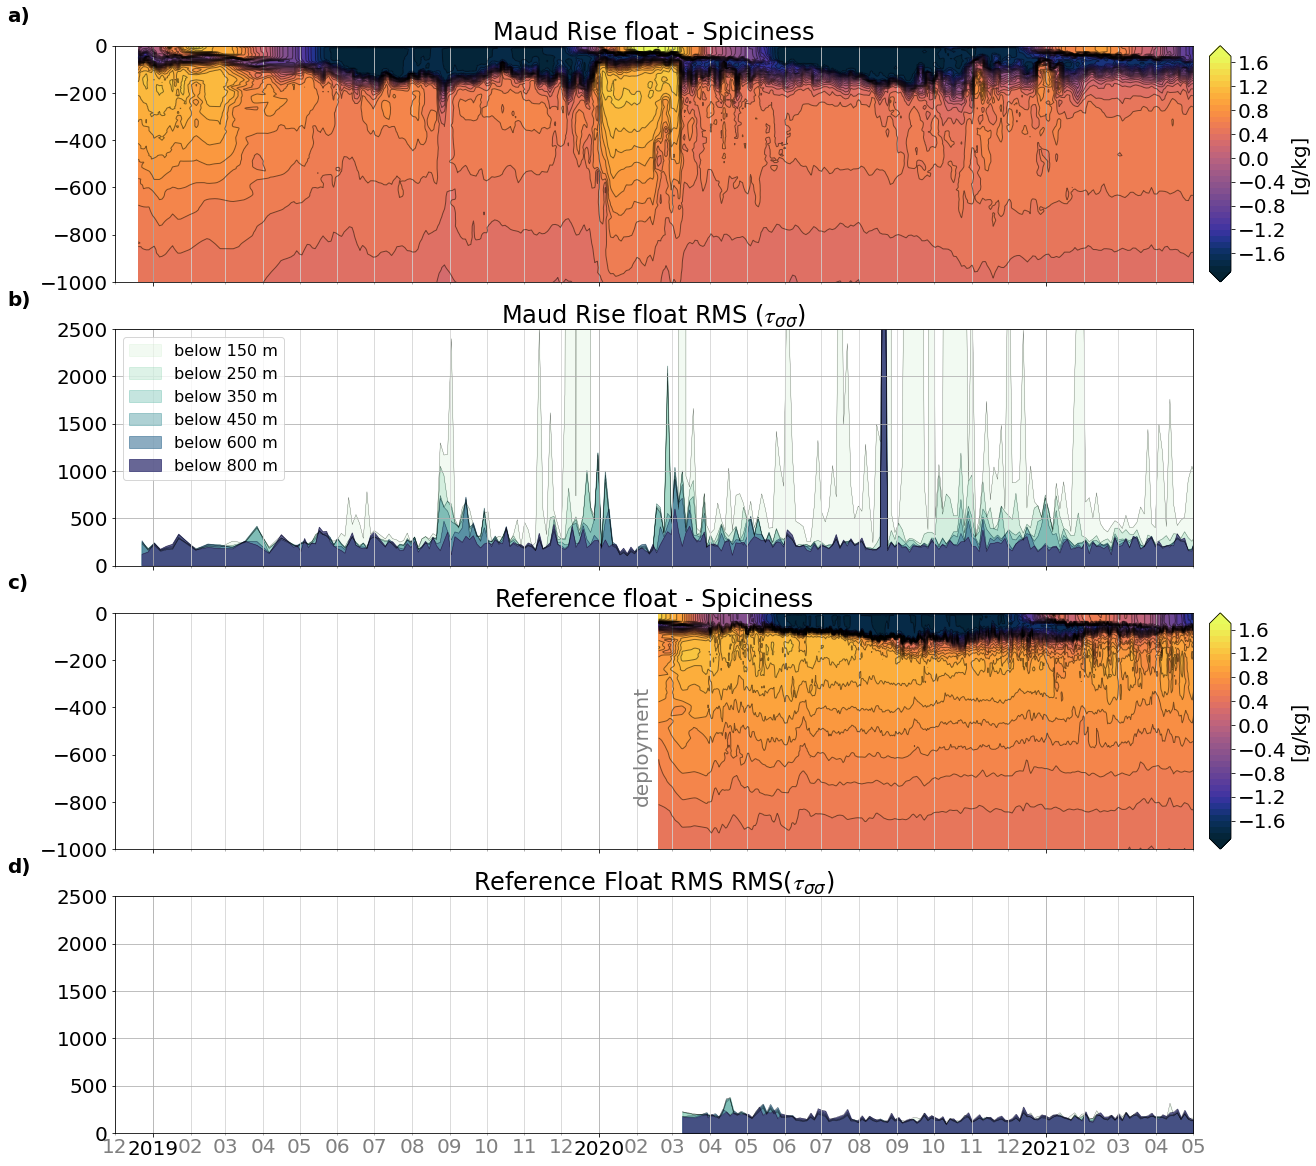

In [35]:
importlib.reload(utils)
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches

original_method = True
if original_method:
    ylim=2500#None
else:
    ylim=17500

mixlat = []
mixlon = []

floatdict = {'300234068638900.nc':'Reference float', 
                 '300234067208900.nc':'Maud Rise float',
                 'GL_PR_PF_5905382.nc':'SOCCOM float 5905382',
                 '5904468_Mprof.nc':'SOCCOM float 5904468',
                 '5904471_Mprof.nc':'SOCCOM float 5904471',
                 'GL_PR_PF_5905382.nc':'SOCCOM float 5905382'
            }

comparisons = ([#['300234067208900.nc','GL_PR_PF_5905382.nc'],
               #['300234067208900.nc', '300234068638900.nc']])#,'GL_PR_PF_5905382.nc'], 
               #['5904468_Mprof.nc', '5904471_Mprof.nc'],
                ['old', 'new']])


for ci,comparison in enumerate(comparisons):
    
    df1, profiles1 = utils.create_dataframe(pfloat=comparison[0], force_reconstruction=False)
    df2, profiles2 = utils.create_dataframe(pfloat=comparison[1], force_reconstruction=False)
    
    profiles1 = profiles1[1:]
    plt.rc('font', size=20)
    fig, axs = plt.subplots(figsize=[20,20], nrows=4, ncols=2, 
                            sharex='col',#False,#'False', 
                            gridspec_kw=dict(height_ratios=[1,1,1,1], 
                            width_ratios=[1, 0.02], wspace=0.03))

    colors = ['tab:red', 'tab:blue']
    linestyles = ['--', 'solid']
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1000)
    cmap = cmocean.cm.deep
    cmap2 = plt.cm.autumn
    cmaps = [cmap, cmap, cmap]
    dindexdict = {0:1, 1:3}
    for dindex,profiles in enumerate([profiles1, profiles2]):
        for i,upperdepthlimit in enumerate([150, 250, 350, 450, 600,800]):
            
            color = cmaps[dindex](norm(upperdepthlimit))#colors[i]
            rms, indices, dates = utils.compute_diapycnal_spice_variations(
                                               profiles, 
                                               upperdepthlimit=upperdepthlimit, 
                                               lowerdepthlimit=1600, 
                                               skipnan=True,
                                               original_method=original_method)
            multiplicator = 1 if dindex == 1 else 1
            if dindex in [2]:
                multiplicator = 0.1 #if dindex == 1 else 0.1
            label='below %s m'%(upperdepthlimit) #if dindex == 0 else None
            axs[dindexdict[dindex]][0].plot(dates, multiplicator*numpy.array(rms), 
                                         color='k', #alpha=upperdepthlimit/1000, 
                        zorder=-10, lw=0.2)
            axs[dindexdict[dindex]][0].fill_between(dates, multiplicator*numpy.array(rms), 
                                                 alpha=upperdepthlimit/1000,
                                color=color, zorder=-10, label=label)
            
    axs[1][0].legend(loc='upper left', fontsize=16)
    #plt.legend()
    
    variable = 'tem'
    names = ['Maud Rise float - %s'%limits.titles['spice'], 
             'Maud Rise float RMS ($𝜏_{\sigma \sigma}$)', 
             'Reference float - %s'%limits.titles['spice'], 
             'Reference Float RMS RMS($𝜏_{\sigma \sigma}$)']
    for index in [1,3]:
        axs[index][0].grid(axis='y')

        axs[index][0].set_ylim(0,ylim)
        axs[index][0].set_xlim(datetime.date(2018,12,1), datetime.date(2021,5,1))
        axs[index][0].set_title(names[index])
        utils.style_timeaxis(axs[index][0])
                
        # --- ab hier zum plotten der heatmap unter den rms
        
    for num,index in enumerate([0,2]):
        #axs[index].set_ylim(-1000,0)
        axs[index][0].set_title(names[index])
        ax = axs[index][0]
        cax  = axs[index][1]
        df = eval('df'+str(num+1))
        
        limits.maxs['den'] = 27.9
        limits.mins['den'] = 27.7
        limits.steplengths['den'] = 0.01
        limits.steplengths['spice'] = 0.01
        limits.mins['spice'] = -0.4

        if variable in ['sal', 'den', 'tem', 'spice']:
            df['spice'] = gsw.spiciness0(df['sal'], df['tem'])
            xi, yi, grid_z0 = utils.create_datagrid(df=df, variable=variable)
            colors, lines = utils.create_contourplot(
                xi=xi, yi=yi, grid_z0=grid_z0, ax=ax, maxdepth=1000, cmap=limits.mcolors[variable],#cmocean.cm.haline, 
                vmin=limits.mins[variable], vmax=limits.maxs[variable], steplength=limits.steplengths[variable],
                linewidths=1)
        
        # block for using spice start
        elif variable in ['spice']:
            xi, yi, grid_z0 = utils.create_datagrid(df=df, variable='sal')
            dens_ax, spice2d, depths2d, densities2d, nsq2d = utils.create_spice2d(
                df=df, variable='den')
            xi = [datetime.datetime.fromtimestamp(fdate) for fdate in xi]
            colors = ax.pcolor(matplotlib.dates.date2num(xi),
                -dens_ax,numpy.stack(spice2d, axis=0))#, vmin=vmin, vmax=vmax)
        
        cbar = plt.colorbar(mappable=colors, cax=axs[index][1])
        cbar.set_label('[g/kg]')

    rect1 = patches.Rectangle(xy=(datetime.date(2018,1,1), -2000), 
                             width=datetime.timedelta(days=410+370), # 390 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')
    
    rect1x = patches.Rectangle(xy=(datetime.date(2018,1,1), 0), 
                             width=datetime.timedelta(days=410+370), 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')
    
    rect2 = patches.Rectangle(xy=(datetime.date(2020,5,15), 0), 
                             width=datetime.timedelta(days=900), 
                             height=3e5, linewidth=1, 
                             edgecolor='k', facecolor='lightgrey')

    axs[2][0].text(0.48,0.2, 'deployment',transform=ax.transAxes, rotation='vertical', color='grey')
    axs[1,1].remove()
    axs[3,1].remove()
    
    for index,ax in enumerate([axs[0][0], axs[1][0], axs[2][0], axs[3][0]]):   
        ax.text(-0.1, 1.1, string.ascii_lowercase[index]+')', transform=ax.transAxes, 
            size=20, weight='bold')
    plt.savefig('../plots/figures/figure4.png', dpi=200)

Returning previously computed DataFrame...


(17866.0, 18748.0)

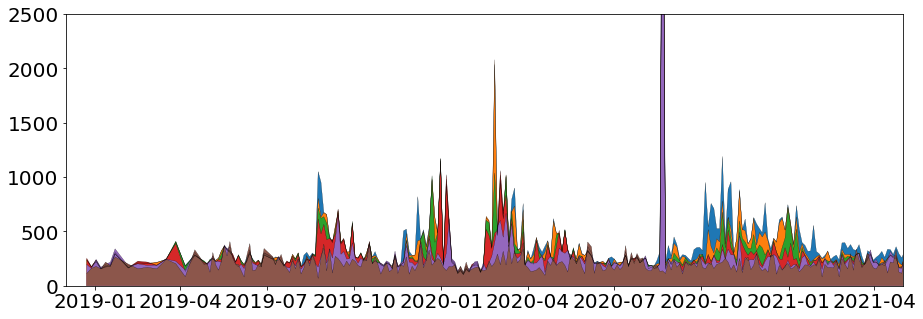

In [153]:
importlib.reload(utils)
fig, ax = plt.subplots(figsize=[15,5])
df, profiles = utils.create_dataframe(pfloat='old', force_reconstruction=False)

for i,upperdepthlimit in enumerate([250, 300, 400, 500, 700,1000]):
    rms, indices, dates = utils.compute_diapycnal_spice_variations(
                                       profiles, 
                                       upperdepthlimit=upperdepthlimit, 
                                       lowerdepthlimit=1600, 
                                       skipnan=True,
                                       original_method=True)

    label='below %s m'%(upperdepthlimit)
    ax.plot(dates, 1*numpy.array(rms), 
            color='k', 
            zorder=-10, lw=0.2)
    ax.fill_between(dates, 1*numpy.array(rms), 
                    alpha=1, 
                    zorder=-10, 
                    label=label)
    
ymax = 2.5e3
ax.set_ylim(0,ymax)
ax.set_xlim(datetime.date(2018,12,1), datetime.date(2021,5,1))

#gsw.rho()
#profile['den'] = gsw.sigma0(profiles[10]['sal'], profiles[10]['tem'])
#profiles[10]['tem']